ライブラリのインポート

In [1]:
from qulacs import Observable, QuantumState, QuantumCircuit, ParametricQuantumCircuit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qulacsvis import circuit_drawer
from qulacs.gate import DenseMatrix
from scipy.optimize import minimize

パラメータ

In [2]:
n_qubits = 5

x_min = -1.
x_max = 1.
n_data = 50

# 学習したい関数
func_to_learn = lambda x: np.sin(x*np.pi)

# 乱数のシード
random_seed = 0

# 乱数発生機の初期化
np.random.seed(random_seed)

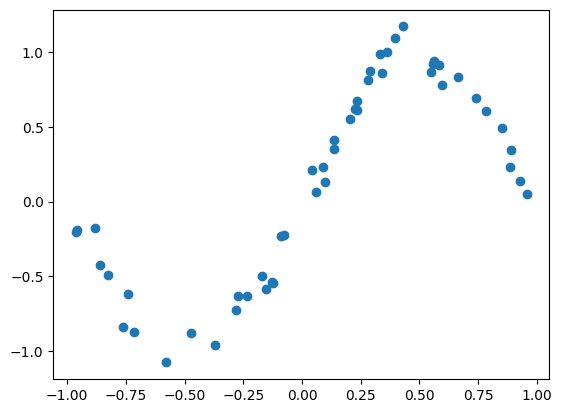

In [3]:
X = x_min + (x_max - x_min) * np.random.rand(n_data)
y_clean = func_to_learn(X)
y = y_clean + np.random.randn(n_data)*0.1
plt.scatter(X,y)
plt.show()

量子回路

In [4]:
state = QuantumState(n_qubits) # 初期状態
state.set_zero_state()

# 入力データをエンコードするゲートを作成する関数
def U_in(x, n_qubits=5):
    U = QuantumCircuit(n_qubits)
    
    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)
    
    print(angle_y)
    
    for i in range(n_qubits-3):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)
    
    return U

print("\n")

def toffoli_gate():
    toffoli = [
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0]
    ]
    
    return DenseMatrix([2, 3, 4], toffoli)

def U_out(n_qubits=5):
    U = ParametricQuantumCircuit(n_qubits)
    
    # parametric gates
    for i in range(2):
        angle = 2*np.pi*np.random.rand()
        U.add_parametric_RZ_gate(i, angle)
        angle = 2*np.pi*np.random.rand()
        U.add_parametric_RY_gate(i, angle)
        angle = 2*np.pi*np.random.rand()
        U.add_parametric_RZ_gate(i, angle)
    
    U.add_H_gate(2)
    U.add_H_gate(3)
    U.add_X_gate(4)
    U.add_H_gate(4)
    
    U.add_CNOT_gate(1, 3)
    U.add_CNOT_gate(0, 2)
    
    U.add_X_gate(2)
    U.add_X_gate(3)
    
    # toffoli gate
    U.add_gate(toffoli_gate())
    
    U.add_X_gate(2)
    U.add_X_gate(3)
    
    U.add_CNOT_gate(0, 2)
    U.add_CNOT_gate(1, 3)
    
    # diffusion gate
    U.add_H_gate(2)
    U.add_H_gate(3)
    U.add_X_gate(2)
    U.add_X_gate(3)
    U.add_H_gate(3)
    U.add_CNOT_gate(2,3)
    U.add_H_gate(3)
    U.add_X_gate(2)
    U.add_X_gate(3)
    U.add_H_gate(2)
    U.add_H_gate(3)
    
    # parametric gates
    for i in range(2):
        angle = 2*np.pi*np.random.rand()
        U.add_parametric_RZ_gate(i+2, angle)
        angle = 2*np.pi*np.random.rand()
        U.add_parametric_RY_gate(i+2, angle)
        angle = 2*np.pi*np.random.rand()
        U.add_parametric_RZ_gate(i+2, angle)
    
    return U

print('U_out')
circuit_drawer(U_out(n_qubits=5))
U_out = U_out(n_qubits=5)



U_out

###############################################################################
>> 0
   ___     ___     ___                                                         
  |pRZ|   |pRY|   |pRZ|                                                        
--|   |---|   |---|   |-------------●-------------------------------●----------
  |___|   |___|   |___|             |                               |          
   ___     ___     ___              |                               |          
  |pRZ|   |pRY|   |pRZ|             |                               |          
--|   |---|   |---|   |-----●-------|-------------------------------|-------●--
  |___|   |___|   |___|     |       |                               |       |  
   ___                      |      _|_     ___     ___     ___     _|_      |  
  | H |                     |     |CX |   | X |   |DeM|   | X |   |CX |     |  
--|   |---------------------|-----|   |---|   |---|   |---|   |---|   |-----|--
  |___|                   

パラメータθを更新する関数

In [5]:
def set_U_out(theta):
    global U_out
    
    params_cmt = U_out.get_parameter_count()
    
    for i in range(params_cmt):
        U_out.set_parameter(i, theta[i])

出力 (予測値) は 3 qubit 目の 𝑍 期待値を取ることにする。

In [6]:
# オブザーバブルの設定
observable = Observable(n_qubits)
observable.add_operator(1., "Z 2")

observable.get_expectation_value(state)


def predict(x, U_out):
    state = QuantumState(n_qubits)
    state.set_zero_state()
    
    # 入力状態の準備
    U_in(x).update_quantum_state(state)
    
    # 出力状態計算
    U_out.update_quantum_state(state)
    
    # モデルの出力
    res = observable.get_expectation_value(state)
    
    return res


コスト関数を定義する。
コスト関数は、MSEを用いる。

In [7]:
def get_cost(theta):
    set_U_out(theta)
    
    # 予測結果の取得
    y_pred = [predict(x, U_out) for x in X]
    
    loss = ((y_pred - y) ** 2).mean()
    
    print("LOSS :", loss)
    
    return loss

In [8]:
params_cnt = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(params_cnt)]

theta_init

[4.14799267096281,
 1.8226113595664735,
 3.88310546309581,
 2.6940332019609157,
 0.851208649826403,
 1.8741631278382846,
 3.5811951525261123,
 3.7125630518871535,
 3.6085919651139333,
 4.104181793964002,
 4.097285684838374,
 2.71068197476515]

学習を行う

In [9]:
%%time

result = minimize(get_cost, theta_init, method='Nelder-Mead')

0.09778275782329132
0.44491231446252155
0.20700191969122284
0.08988736148757666
-0.15329002695270819
0.2960958909466078
-0.12515203173298478
0.9003525371684761
1.1872022424159143
-0.2352817296039392
0.6229703235736507
0.057822054399491715
0.1365127295724572
1.0182546667675143
-1.0312228292399164
-0.9715153642331431
-1.2854463848679236
0.7278148027910747
0.5899428116777606
0.8331064819341766
1.2772946294004632
0.6413991745844967
-0.07711769102984223
0.5956637959283839
-0.8686398171783901
0.2836295742545571
-0.7941861262510993
1.095894977594191
0.043710561166060286
-0.17151581674085048
-0.4902979697666289
0.5805302318456204
-0.08781214490801523
0.13729886094943414
-1.295778656366548
0.23749737939074253
0.2261132830905641
0.23605411071593985
1.0918829023464067
0.3721730797338958
-0.28481946984991313
-0.12627137984709771
0.406353486590769
-1.0749136270203166
0.3400491529292701
0.3482737862016337
-0.6177897622019898
-0.8362686502570833
-0.3780870449844034
-0.2760719559032872
LOSS : 0.547519

In [10]:
# 最適化後のコスト関数の値
print(result.fun)

# 最適化によるthetaの解
theta_opt = result.x
print(theta_opt)

0.42729386974803224
[4.25497428 1.85873542 3.92342713 2.76717307 0.85567309 1.87809997
 3.72491776 3.31295996 3.61573816 4.1177688  4.08163576 2.68584475]


結果のプロット

-1.5707963267948966
-1.3704614844717768
-1.2870022175865687
-1.2226303055219356
-1.1680804852142348
-1.119769514998634
-1.0758622004540008
-1.0352696724805086
-0.9972832223717996
-0.9614110187641013
-0.927295218001612
-0.8946658172342349
-0.8633131150155533
-0.8330703583416474
-0.8038023189330297
-0.7753974966107527
-0.7477626346599202
-0.7208187608700892
-0.6944982656265556
-0.6687427032023713
-0.6435011087932839
-0.6187286906722507
-0.5943858000010618
-0.5704371093999214
-0.5468509506959436
-0.5235987755982984
-0.5006547124045876
-0.47799519851895184
-0.45559867339582283
-0.4334453200698854
-0.41151684606748745
-0.38979629647425995
-0.36826789343663935
-0.3469168975271611
-0.3257294872946295
-0.30469265401539686
-0.2837941092083272
-0.26302220290846823
-0.24236585103896255
-0.2218144704967937
-0.20135792079033007
-0.18098645124654697
-0.16069065295190985
-0.14046141470985504
-0.12028988239478729
-0.100167421161559
-0.08008558003365819
-0.06003605844527759
-0.04001067435398807
-0.0200

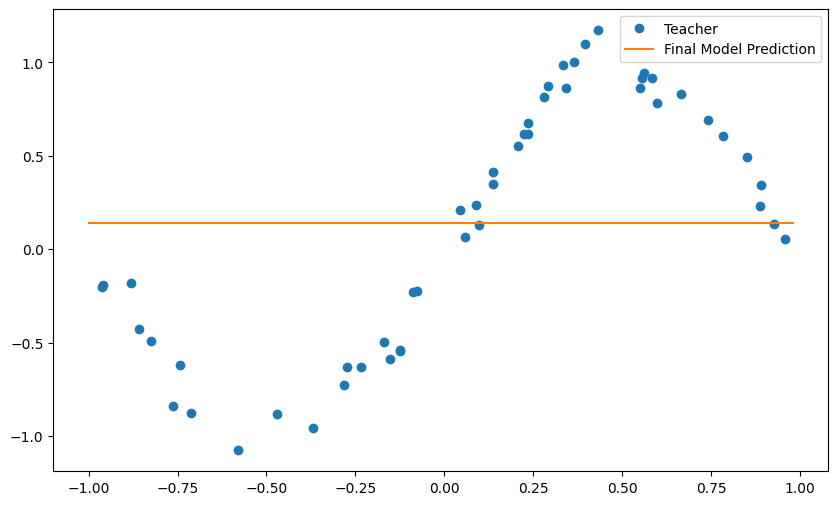

In [11]:
# U_outに最適化されたthetaを代入
set_U_out(theta_opt)

# プロット
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(X, y, "o", label='Teacher')


# モデルの予測値
y_pred = np.array([predict(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()